In [1]:
from PIL import Image
from shapely.geometry import Polygon, box, LineString, Point
from shapely.ops import unary_union
from scipy import ndimage
from scipy.spatial import KDTree
from skimage.morphology import skeletonize
import numpy as np
import geopandas as gpd
import pandas as pd
import networkx as nx
import pandana as pdna
import random
import datetime

In [2]:
import sys
sys.path.append('../Diffusion-Models-pytorch/')
from diffusion import ConditionalDiffusion
from modules import UNet_conditional, EMA
from torch import nn, load, FloatTensor
import gradio as gr
import torchvision.transforms as T

/mas/u/doorleyr/.pyenv/versions/lu_gen_sim/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
start_x, start_y = 330874, 4684290
scale=2
utm_zone = 19
utm_crs = f"+proj=utm +zone={utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"

max_floors=21

VIRTUAL_FLOOR_HEIGHT=3

cmap={
    'Resi' : [255,255,51],
    'Comm' : [228,26,28],
    'Inst' : [55,126,184],
    'None' : [0,0,0],
    'Open' : [77,175,74],
    'Road': [100, 100, 100]
}

rgb_label_dict={}
label_to_lu={}
for i, (k,v) in enumerate(cmap.items()):
    rgb_label_dict[tuple(v)]=i
    label_to_lu[i]=k

In [4]:
# image = Image.open("../Diffusion-Models-pytorch/test_image.png")

In [5]:
# image

In [6]:
def create_grid(cell_size, total_depth, total_width, start_x, start_y, crs):
    """
    Here, start_x and start_y should be the edge of the grid cell, not the centre
    """
    top_left_grid=[]
    for i in range(int(total_depth/ cell_size)):
        for j in range(int(total_width/ cell_size)):
            top_left_grid.append([start_x+j*cell_size, 
                                     start_y-i*cell_size])
    cells=[]
    for i in range(len(top_left_grid)):
        coords=[top_left_grid[i], 
                [top_left_grid[i][0]+cell_size, top_left_grid[i][1]], 
                [top_left_grid[i][0]+cell_size, top_left_grid[i][1]-cell_size], 
                [top_left_grid[i][0], top_left_grid[i][1]-cell_size],
                top_left_grid[i]]
        cell_poly=Polygon(coords)
        cells.append(cell_poly)
    cells_gdf=gpd.GeoDataFrame(geometry=cells, crs=crs)
    cells_gdf['cell_id']=list(range(len(cells_gdf)))
    centroids=cells_gdf.centroid
    cells_gdf['x']=[c.x for c in centroids]
    cells_gdf['y']=[c.y for c in centroids]
    return cells_gdf

def rgb_distance(rgb1, rgb2):
    return np.sqrt(np.sum([(rgb1[i] - rgb2[i]) ** 2 for i in range(3)]))

def closest_rgb_label(pixel, rgb_label_dict):
    min_distance = float('inf')
    closest_label = None
    for rgb, label in rgb_label_dict.items():
        distance = rgb_distance(pixel[:3], rgb)
        if distance < min_distance:
            min_distance = distance
            closest_label = label
    return closest_label

def create_graph(arr, node_val=255, diag=False):
    # for a single color channel (lu type or road)
    # iterate through rows and cols
    # for each pixel, if active, check to right, below (and diag for road)
    # if both active, create a link
    G=nx.Graph()
    nrows=arr.shape[0]
    ncols=arr.shape[1]
    for i in range(nrows-1):
        for j in range(ncols-1):
            if arr[i, j]==node_val:
                if arr[i+1, j]==node_val:
                    G.add_edge(i*ncols+j, (i+1)*ncols+j)
                if arr[i, j+1]==node_val:
                    G.add_edge(i*ncols+j, i*ncols+j+1)
                if (diag and (arr[i+1, j+1]==node_val)):
                    G.add_edge(i*ncols+j, (i+1)*ncols+j+1)
    return G

def create_geometries(G, grid_gdf):
    components=[c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    for i, c in enumerate(components):
        grid_gdf.loc[list(c), 'component']='c'+str(i)
    parcels=grid_gdf.loc[~grid_gdf['component'].isnull()].dissolve(by='component', aggfunc={'alpha': 'mean'})
    parcels['floors']=(parcels['alpha']*(max_floors/255)).astype(int)
    return parcels

def create_geodataframe(image, rgb_label_dict, grid_gdf, simplify=False):
    # Convert the RGBA PIL image to a numpy array
    np_img = np.array(image)
    grid_gdf['alpha']=np_img[:, :, 3].flatten()
    # np_img= np.flip(np_img, axis=0)

    # Identify the closest RGB value and its corresponding label for each pixel
    label_img = np.zeros((np_img.shape[0], np_img.shape[1]), dtype=int)
    for i in range(np_img.shape[0]):
        for j in range(np_img.shape[1]):
            label_img[i, j] = closest_rgb_label(np_img[i, j], rgb_label_dict)
            
    all_geoms=[]
    for label in label_to_lu:
        l_array=(label_img==label).astype(int)
        l_graph=create_graph(l_array, node_val=1, diag=False)
        if len(l_graph.nodes)>0:
            l_geom=create_geometries(l_graph, grid_gdf.copy())
            l_geom['lu']=label_to_lu[label]
            all_geoms.append(l_geom)
    gdf = pd.concat(all_geoms)
    gdf=gdf.reset_index(drop=True)
    gdf['id']=gdf.index.copy()
    
    if simplify: gdf.geometry=gdf.geometry.apply(lambda g: g.simplify(tolerance=scale))
    return gdf, label_img

# Function to compute the angle between two vectors
def compute_angle(node1, node2, node3):
    vector1 = np.array(node1) - np.array(node2)
    vector2 = np.array(node3) - np.array(node2)
    dot_product = np.dot(vector1, vector2)
    determinant = np.cross(vector1, vector2)
    angle = np.arctan2(determinant, dot_product) * (180 / np.pi)
    return abs(angle)

# Function to compute the angle between two vectors
def compute_angle(node1, node2, node3):
    vector1 = np.array(node1) - np.array(node2)
    vector2 = np.array(node3) - np.array(node2)
    dot_product = np.dot(vector1, vector2)
    determinant = np.cross(vector1, vector2)
    angle = np.arctan2(determinant, dot_product) * (180 / np.pi)
    return abs(angle)

def find_largest_component(edge_table):
    # Create a directed graph from the adjacency table
    graph = nx.from_pandas_edgelist(edge_table, 'from_node', 'to_node', create_using=nx.Graph)

    # Find the largest connected component
    largest_component = max(nx.connected_components(graph), key=len)

    # Get all node IDs in the largest connected component
    return list(largest_component)


def road_network(binary_array, simplify=True):
    # Skeletonize the binary road network
    skeleton = skeletonize(binary_array).astype(np.uint8)

    # Create a graph representation of the skeleton
    graph = nx.Graph()
    for y, x in np.argwhere(skeleton == 1):
        graph.add_node((x, y))

    # Connect neighboring nodes
    for node in graph.nodes:
        x, y = node
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
            neighbor = (x + dx, y + dy)
            if neighbor in graph.nodes:
                graph.add_edge(node, neighbor, length=np.hypot(dx, dy))
    if simplify:
        # Simplify the graph by removing degree-2 nodes iteratively
        degree_2_nodes = [node for node, degree in graph.degree if degree == 2]
        while degree_2_nodes:
            node = degree_2_nodes.pop(0) # start with the first node
            neighbors = list(graph.neighbors(node))
            edge1_length = graph[node][neighbors[0]]['length']
            edge2_length = graph[node][neighbors[1]]['length']
            if len(neighbors) > 1 and neighbors[0] != neighbors[1]: # check that there are at least 2 different neighbors
                angle = compute_angle(neighbors[0], node, neighbors[1])
                if ((170 <= angle <= 190) or ((edge1_length < 3) and (edge2_length < 3))):
                    graph.remove_node(node) # remove the node from the graph
                    graph.add_edge(neighbors[0], neighbors[1], length=np.hypot(neighbors[0][0] - neighbors[1][0], neighbors[0][1] - neighbors[1][1]))  # Connect the neighbors and calculate new edge length
                    degree_2_nodes = [node for node, degree in graph.degree if degree == 2] # refresh the list of degree-2 nodes

    # Create node and edge tables
    node_table = pd.DataFrame({'node_id': range(len(graph.nodes)), 'x': [node[0] for node in graph.nodes], 'y': [node[1] for node in graph.nodes]})
    node_id_map = {node: node_id for node_id, node in enumerate(graph.nodes)}
    
    # update node positions and scale
    node_table['x']=(scale * node_table['x']) +start_x
    node_table['y']=(scale * (-1) * node_table['y']) +start_y
    
    edge_table = pd.DataFrame([(node_id_map[u], node_id_map[v], scale * np.sqrt((u[0] - v[0])**2 + (u[1] - v[1])**2)) for u, v in graph.edges], columns=['from_node', 'to_node', 'distance'])
    
    node_table=node_table.set_index('node_id')
    
    # connected_nodes = find_largest_component(edge_table)
    # node_table=node_table.loc[connected_nodes]
    # edge_table=edge_table.loc[((edge_table['from_node'].isin(connected_nodes))&
    #                            (edge_table['to_node'].isin(connected_nodes)))]
    
    return node_table, edge_table


def get_bld_floors_gdf(lu_gdf):
    bld_floors=[]
    for ind, row in lu_gdf.iterrows():
        for i in range(int(row['floors'])):
            base_geom=row['geometry']
            base_coords=list(base_geom.exterior.coords)
            floor_coords=[[c[0], c[1], i*VIRTUAL_FLOOR_HEIGHT] for c in base_coords]
            floor_geom=Polygon(floor_coords)
            new_ind=str(row['id'])+'_'+str(i)
            bld_floors.append({'floor': i, 'lu': row['lu'],
                               'geometry': floor_geom, 'ind': new_ind,
                              'id': row.id, 'area': floor_geom.area})
            bld_floors_gdf=gpd.GeoDataFrame(
                bld_floors, geometry='geometry')
            bld_floors_gdf=bld_floors_gdf.set_index('ind')
    return bld_floors_gdf

def create_virtual_nodes(bld_floors_gdf, max_real_node_id):
    virtual_nodes=[]
    for ind, row in bld_floors_gdf.iterrows():
        centroid=row.geometry.centroid
        x, y= centroid.x, centroid.y
        z=row.geometry.exterior.coords[0][2]
        virtual_nodes.append({'x': x, 'y': y, 'z': z,'bld_ind': ind, 'floor': row['floor']})
    virtual_nodes=pd.DataFrame(virtual_nodes)    
    virtual_nodes['id_int']=list(range(max_real_node_id+1, max_real_node_id+1+len(virtual_nodes)))
    node_id_map={row['bld_ind']: row['id_int'] for ind, row in virtual_nodes.iterrows()}
    return virtual_nodes, node_id_map

def create_vertical_edges(bld_floors_gdf, node_id_map):
    vertical_edges=[]
    for bld in bld_floors_gdf['id'].unique():
        floors_this_bld=bld_floors_gdf.loc[bld_floors_gdf['id']==bld]
        min_floor=floors_this_bld['floor'].min()
        max_floor=floors_this_bld['floor'].max()
        for f in range(min_floor, max_floor-1):
            vertical_edges.append({'from_floor_id': '{}_{}'.format(bld, f),
                                'to_floor_id': '{}_{}'.format(bld, f+1),
                                'travel_time': 10,
                                 'net_type': 'vertical'})
            vertical_edges.append({'to_floor_id': '{}_{}'.format(bld, f),
                                'from_floor_id': '{}_{}'.format(bld, f+1),
                                'travel_time': 10,
                                'net_type': 'vertical'})
    vertical_edges=pd.DataFrame(vertical_edges)
    vertical_edges['from_node']=vertical_edges['from_floor_id'].apply(lambda i: node_id_map[i])
    vertical_edges['to_node']=vertical_edges['to_floor_id'].apply(lambda i: node_id_map[i])
    return vertical_edges

def create_ground_connections(nodes_df, virtual_nodes):
    tree=KDTree(nodes_df[['x', 'y']])
    id_int_ls=list(nodes_df.index)

    ground_virt_nodes=virtual_nodes.loc[virtual_nodes['floor']==0]
    connection_edges=[]
    for ind, row in ground_virt_nodes.iterrows():
        dist, closest_real_node_ind=tree.query([row['x'], row['y']])
        connection_edges.append({'to_node': row['id_int'],
                                'from_node': id_int_ls[closest_real_node_ind],
    #                             'travel_time': dist/(4.8/3.6),
                                 'travel_time':100,
                                'net_type': 'connection'})
        connection_edges.append({'from_node': row['id_int'],
                                'to_node': id_int_ls[closest_real_node_ind],
    #                             'travel_time': dist/(4.8/3.6),
                                 'travel_time':100,
                                'net_type': 'connection'})
    return connection_edges

def create_3d(lu_gdf, nodes_df, edges_df):
    bld_floors_gdf= get_bld_floors_gdf(lu_gdf.loc[~(lu_gdf['lu'].isin(['Road', 'None']))])
    bld_floors_gdf.crs= utm_crs

    virtual_nodes, node_id_map = create_virtual_nodes(
        bld_floors_gdf, max_real_node_id=nodes_df.index.max())

    vertical_edges = create_vertical_edges(bld_floors_gdf, node_id_map)
    connection_edges=create_ground_connections(nodes_df, virtual_nodes)
    virtual_edges=pd.concat([vertical_edges, pd.DataFrame(connection_edges)])

    virtual_nodes=virtual_nodes.set_index('id_int')
    nodes_df['floor']=0
    nodes_df['z']=0
    all_nodes=pd.concat([nodes_df[['x', 'y', 'z', 'floor']], 
                         pd.DataFrame(virtual_nodes[['x', 'y', 'z', 'floor']])])

    edges_df['net_type']='walk'
    edges_df['travel_time']=edges_df['distance']/(4.8/3.6)
    all_edges=pd.concat([edges_df[['from_node', 'to_node', 'net_type', 'travel_time']],
                        virtual_edges[['from_node', 'to_node', 'net_type', 'travel_time']]],
                       ignore_index=True)

    all_nodes['geometry']=all_nodes.apply(
        lambda row: Point(row['x'], row['y'], row['z']), axis=1)
    all_nodes_gdf=gpd.GeoDataFrame(all_nodes, geometry='geometry', crs=utm_crs)

    bld_floors_wgs=bld_floors_gdf.to_crs('epsg:4326')
    all_nodes_wgs=all_nodes_gdf.to_crs('epsg:4326')
    all_nodes_wgs['lon']=all_nodes_wgs.geometry.x
    all_nodes_wgs['lat']=all_nodes_wgs.geometry.y

    all_edges=all_edges.set_index(['from_node', 'to_node'], drop=False)
    return bld_floors_wgs, all_nodes_wgs, all_edges, node_id_map

def get_edge_attr_lookup(all_edges):
    edge_attr_lookup=all_edges[['travel_time']].to_dict(orient='index')
    other_way_edge_attr_lookup={}
    for ind in edge_attr_lookup:
        if (ind[1], ind[0]) not in edge_attr_lookup:
            other_way_edge_attr_lookup[ind[1], ind[0]]=edge_attr_lookup[ind]
    for ind in other_way_edge_attr_lookup:
        edge_attr_lookup[ind]=other_way_edge_attr_lookup[ind]
    return edge_attr_lookup


def get_trip(path, node_id_to_coords, attr_lookup, profile,
             start_coord, end_coord,
             travel_time_col='travel_time', 
             trip_start_time=0, time_window=500):
    weights= []
    types=[]
    for i in range(len(path)-1):
        weights.append(attr_lookup[(path[i], path[i+1])][travel_time_col])
    
    coords=[start_coord] + [node_id_to_coords[n] for n in path] +[end_coord]
    
    st= trip_start_time + random.randint(1, time_window)
    t_first_node = st + 30
    times=[st, t_first_node]+list(t_first_node+ np.cumsum(weights))
    times+= [times[-1]+30]
    times=[int(t) for t in times]
    
    return {'path': coords, 'timestamps': times, 
#             'edge_types':types, 
            'profile': profile
           }

def generate_random_point_in_polygon(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    while True:
        p = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(p):
            return [p.x, p.y, polygon.exterior.coords[0][2]]
        
def create_hw_trips(bld_floors_wgs, net_3d, node_id_to_coords, edge_attr_lookup, node_id_map, N=1000, profile_name='commuter', from_lu='Resi', to_lu='Comm'):
    if (bld_floors_wgs['lu']=='Resi').sum() >0:
        sources=bld_floors_wgs.loc[bld_floors_wgs['lu']=='Resi'].sample(
            N, replace=True, weights='area')
    else:
        sources=bld_floors_wgs.sample(N, replace=True, weights='area')
        
    if (bld_floors_wgs['lu']=='Comm').sum()>0:
        targets=bld_floors_wgs.loc[bld_floors_wgs['lu']=='Comm'].sample(
            N, replace=True, weights='area')
    else:
        targets=bld_floors_wgs.sample(N, replace=True, weights='area')

    source_nodes=[node_id_map[s] for s in list(sources.index)]
    target_nodes=[node_id_map[s] for s in list(targets.index)]
    
    start_points=sources['geometry'].apply(generate_random_point_in_polygon)
    end_points=targets['geometry'].apply(generate_random_point_in_polygon)

    paths=net_3d.shortest_paths(source_nodes, 
                             target_nodes, 
                             imp_name='travel_time')
    trips=[]
    for ip, p in enumerate(paths):
        if len(p)>0:
            trips.append(get_trip(p, node_id_to_coords, edge_attr_lookup, profile_name,
                            start_points[ip], end_points[ip], 'travel_time', 
                            trip_start_time=7*3600))
    return trips

# def create_stays(trips):
#     stays=[]
#     for t in trips:
#         if len(t['timestamps'])>1:
#             start_point=t['path'][0]
#             end_point=t['path'][-1]
#             start_time=t['timestamps'][0]
#             end_time=t['timestamps'][-1]
#             stays.append({'profile': t['profile'],
#                  'from': 0,
#                  'to': start_time,
#                  'lon': start_point[0]+random.gauss(0, 0.0002),
#                  'lat': start_point[1]+random.gauss(0, 0.0002),
#                  'z': start_point[2]+1.5})
#             stays.append({'profile': t['profile'],
#                  'from': end_time,
#                  'to': 3600*24,
#                  'lon': end_point[0]+random.gauss(0, 0.0001),
#                  'lat': end_point[1]+random.gauss(0, 0.0001),
#                  'z': end_point[2]+1.5}) 
#     return stays

def image_to_3d(image, grid_gdf):
    lu_gdf, label_img = create_geodataframe(image, rgb_label_dict, grid_gdf)
    # lu_gdf['lu']=lu_gdf['label'].apply(lambda l:  label_to_lu[l]) 
    
    nodes_df, edges_df =road_network(binary_array=(label_img==5).astype(int), simplify=True)
    bld_floors_wgs, all_nodes_wgs, all_edges, node_id_map =create_3d(lu_gdf, nodes_df, edges_df)
    
    node_id_to_coords={ind: [row['lon'], row['lat'], row['z']] for ind, row in all_nodes_wgs.iterrows()}
    edge_attr_lookup= get_edge_attr_lookup(all_edges)
    
    net_3d=pdna.network.Network(all_nodes_wgs['lon'], all_nodes_wgs['lat'], 
                            all_edges['from_node'], all_edges['to_node'], 
                            edge_weights=all_edges[['travel_time']], twoway=True)
    return bld_floors_wgs, net_3d, node_id_to_coords, edge_attr_lookup, node_id_map, all_nodes_wgs
    
#     trips = create_trips(bld_floors_wgs, net_3d, node_id_to_coords, edge_attr_lookup, node_id_map)
    
#     return bld_floors_wgs, trips, stays

In [20]:
def create_HWOWH_trips(N, bld_floors_wgs, net_3d, node_id_to_coords, edge_attr_lookup, node_id_map, durations=[8,4,0.5,4]):
    trips=[{'path': [], 'timestamps':[], 'activities': []} for i in range(N)]                   
    activities = ['H', 'W', 'O', 'W', 'H']
    durations_det=np.array([durations]*N)
    durations_rand=-0.25+0.5*np.random.rand(durations_det.shape[0], durations_det.shape[1])# between -0.25 and 0.25
    durations_rand_scaled=np.multiply(durations_rand, durations)
    durations_total=durations_det+durations_rand_scaled

    start_times=(3600*np.column_stack((np.zeros((N,1)), np.cumsum(durations_total, axis=1)))).astype(int)

    places={}
    
    if (bld_floors_wgs['lu']=='Comm').sum()>0:
        places['W']=bld_floors_wgs.loc[bld_floors_wgs['lu']=='Comm'].sample(
            N, replace=True, weights='area')
    else:
        places['W']=bld_floors_wgs.sample(N, replace=True, weights='area')
        
    if (bld_floors_wgs['lu']=='Resi').sum()>0:
        places['H']=bld_floors_wgs.loc[bld_floors_wgs['lu']=='Resi'].sample(
            N, replace=True, weights='area')
    else:
        places['H']=bld_floors_wgs.sample(N, replace=True, weights='area')
        
#     if (~(bld_floors_wgs['lu']=='Resi')).sum()>0:
#         places['O']=bld_floors_wgs.loc[((~(bld_floors_wgs['lu']=='Resi')) & (bld_floors_wgs['floor']==0))].sample(
#                 N, replace=True, weights='area')
#     else:
#         places['O']=bld_floors_wgs.loc[bld_floors_wgs['floor']==0].sample(N, replace=True, weights='area')
    if (bld_floors_wgs['lu']=='Comm').sum()>0:
        places['O']=bld_floors_wgs.loc[bld_floors_wgs['lu']=='Comm'].sample(
            N, replace=True, weights='area')
    else:
        places['O']=bld_floors_wgs.sample(N, replace=True, weights='area')    

    for i_a in range(len(activities)-1):
        from_places=places[activities[i_a]]
        to_places=places[activities[i_a+1]]

        source_nodes=[node_id_map[s] for s in list(from_places.index)]
        target_nodes=[node_id_map[s] for s in list(to_places.index)]

        start_points=from_places['geometry'].apply(generate_random_point_in_polygon)
        end_points=to_places['geometry'].apply(generate_random_point_in_polygon)

        paths=net_3d.shortest_paths(source_nodes, 
                                 target_nodes, 
                                 imp_name='travel_time')

        for i_p, p in enumerate(paths):
            if len(p)>0:
                new_trip = get_trip(p, node_id_to_coords, edge_attr_lookup, 'commuter',
                                start_points[i_p], end_points[i_p], 'travel_time', 
                                trip_start_time=start_times[i_p][i_a+1])
                trips[i_p]['path'].extend(new_trip['path'])
                trips[i_p]['timestamps'].extend(new_trip['timestamps'])
                trips[i_p]['activities'].extend([activities[i_a+1]] * len(new_trip['path']))
                
    # TODO: FIX NON_VALID TRIPS- PROBABLY DUE TO NON CONNECTED NETWORK
    # ALSO: rethink activity labels in trips- now all labelled with their next activity
    valid_trips = [t for t in trips if ((len(t['path'])>1) and (t['activities'][0]=='W'))]
   
    return valid_trips

In [8]:
MODEL_PATH='../Diffusion-Models-pytorch/models/cond_2023042614_4_500/ckpt.pt'

DEVICE = "cuda"
NOISE_STEPS=500
IMAGE_SIZE=128
CHANNELS=4
TIME_DIM=256
NCLASSES=5 # ['Comm', 'Open', 'Resi', 'Road', 'Inst']

model = nn.DataParallel(
    UNet_conditional(
        image_size=IMAGE_SIZE, c_in=CHANNELS, 
        c_out= CHANNELS, time_dim=TIME_DIM,
        num_classes=NCLASSES)
    ).to(DEVICE)

diffusion = ConditionalDiffusion(
    noise_steps=NOISE_STEPS, 
    img_size=IMAGE_SIZE, device=DEVICE)

model.load_state_dict(load(MODEL_PATH))

<All keys matched successfully>

In [9]:
grid_gdf=create_grid(cell_size=scale, total_depth=scale*128, 
                     total_width=scale*128, 
                     start_x=start_x, start_y=start_y, crs=utm_crs)

In [10]:
def return_images(m1, m2, m3, m4, m5):
    images = diffusion.sample(model, n=1,
                     labels=FloatTensor([[m1/100, m2/100, m3/100, m4/100, m5/100]]), 
                     channels=CHANNELS)
    transform = T.ToPILImage(mode='RGBA')
    pil_ims=[transform(im) for im in images]
    return pil_ims

In [11]:
image=return_images(30, 10, 10, 10, 10)[0]
# ['Comm', 'Open', 'Resi', 'Road', 'Inst']

02:38:17 - INFO: Sampling 1 new images....
499it [00:29, 17.06it/s]


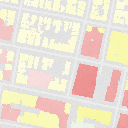

In [12]:
image

In [21]:
then=datetime.datetime.now()
bld_floors_wgs, net_3d, node_id_to_coords, edge_attr_lookup, node_id_map, all_nodes_wgs = image_to_3d(image, grid_gdf)
print(datetime.datetime.now()-then)
# trips = create_trips(bld_floors_wgs, net_3d, node_id_to_coords, edge_attr_lookup, node_id_map)
trips = create_HWOWH_trips(2000, bld_floors_wgs, net_3d, node_id_to_coords, edge_attr_lookup, node_id_map, durations=[8,4,0.5,4])
print(datetime.datetime.now()-then)
print(len(trips))

Generating contraction hierarchies with 40 threads.
Setting CH node vector of size 443
Setting CH edge vector of size 618
Range graph removed 370 edges of 1236
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 0:00:11.161091
0:00:15.550381
1114


In [14]:
# trips = create_HWOWH_trips(N=1000, bld_floors_wgs=bld_floors_wgs, durations=[8,4,0.5,4])

In [15]:
pd.concat([bld_floors_wgs, all_nodes_wgs]).explore(tooltip=[ 'lu'], style_kwds={'opacity': 0.01},
                      tiles='CartoDB Positron')

In [16]:
# import matplotlib.pyplot as plt
# plt.scatter(nodes_df['x'], nodes_df['y'])

# Flask App

In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS

app = Flask(__name__)
CORS(app)  # Enable CORS for all routes

@app.route('/generate', methods=['POST'])
def generate():
    # Retrieve the input dictionary from the request
    input_dict = request.get_json()

    image=return_images(input_dict['Comm'], input_dict['Open'], 
                        input_dict['Resi'],input_dict['Road'], 
                        input_dict['Inst'])[0]
    
    then=datetime.datetime.now()
    bld_floors_wgs, net_3d, node_id_to_coords, edge_attr_lookup, node_id_map, all_nodes_wgs = image_to_3d(image, grid_gdf)
    trips = create_HWOWH_trips(2000, bld_floors_wgs, net_3d, node_id_to_coords, edge_attr_lookup, node_id_map, durations=[8,4,0.5,4])
    print(datetime.datetime.now()-then)

    return jsonify({'blds': bld_floors_wgs.__geo_interface__, 'trips': trips})

@app.route('/default', methods=['GET'])
def get_default():
    return jsonify({'blds': bld_floors_wgs.__geo_interface__, 'trips': trips})
    
    

if __name__ == '__main__':
    app.run(port=3000)

 * Serving Flask app '__main__'
 * Debug mode: off


02:40:37 - INFO: WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:3000
02:40:37 - INFO: Press CTRL+C to quit
02:40:43 - INFO: 127.0.0.1 - - [31/May/2023 14:40:43] "GET /default HTTP/1.1" 200 -
02:41:02 - INFO: 127.0.0.1 - - [31/May/2023 14:41:02] "OPTIONS /generate HTTP/1.1" 200 -
02:41:02 - INFO: Sampling 1 new images....
499it [00:34, 14.62it/s]


Generating contraction hierarchies with 40 threads.
Setting CH node vector of size 367
Setting CH edge vector of size 517
Range graph removed 370 edges of 1034
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 0:00:07.067622


02:41:44 - INFO: 127.0.0.1 - - [31/May/2023 14:41:44] "POST /generate HTTP/1.1" 200 -
02:43:05 - INFO: 127.0.0.1 - - [31/May/2023 14:43:05] "GET /default HTTP/1.1" 200 -
02:43:48 - INFO: 127.0.0.1 - - [31/May/2023 14:43:48] "OPTIONS /generate HTTP/1.1" 200 -
02:43:48 - INFO: Sampling 1 new images....
499it [00:31, 15.64it/s]


Generating contraction hierarchies with 40 threads.
Setting CH node vector of size 339
Setting CH edge vector of size 470
Range graph removed 364 edges of 940
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 0:00:15.856104


02:44:37 - INFO: 127.0.0.1 - - [31/May/2023 14:44:37] "POST /generate HTTP/1.1" 200 -
02:45:03 - INFO: 127.0.0.1 - - [31/May/2023 14:45:03] "GET /default HTTP/1.1" 200 -
02:45:18 - INFO: 127.0.0.1 - - [31/May/2023 14:45:18] "OPTIONS /generate HTTP/1.1" 200 -
02:45:18 - INFO: Sampling 1 new images....
499it [00:27, 18.29it/s]


Generating contraction hierarchies with 40 threads.
Setting CH node vector of size 316
Setting CH edge vector of size 423
Range graph removed 274 edges of 846
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 0:00:09.705702


02:45:56 - INFO: 127.0.0.1 - - [31/May/2023 14:45:56] "POST /generate HTTP/1.1" 200 -
